# Simple LSTM for track finding on 1D detector layers

In [1]:
# System imports
from __future__ import print_function

# External imports
import numpy as np
from keras import models
from keras import layers

# Local imports
from data import (generate_straight_track, generate_straight_tracks,
                  generate_uniform_noise, generate_track_bkg)
from drawing import draw_event, draw_input_and_pred

from matplotlib import pyplot as plt
%matplotlib notebook

Using TensorFlow backend.


## Data generation

In [2]:
# Config parameters
det_width = 50
det_depth = 50
det_shape = (det_depth, det_width)
num_events = 100000

In [3]:
# Generate a sample of single-track events
tracks = generate_straight_tracks(num_events, det_shape)
train_input = tracks[:,:-1,:]
train_target = tracks[:,1:,:]
print(train_input.shape)

(100000, 49, 50)


## Simple LSTM track fitting model

In [4]:
def build_model(num_hidden=10, length=det_depth-1, dim=det_width,
                loss='categorical_crossentropy',
                optimizer='Nadam', metrics=['accuracy']):
    inputs = layers.Input(shape=(length, dim))
    hidden = layers.LSTM(output_dim=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(dim, activation='softmax'))(hidden)
    model = models.Model(input=inputs, output=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [9]:
# Instantiate the model
model1 = build_model()
# Train on the entire training set
%time model1.fit(train_input, train_target, batch_size=500, nb_epoch=10)
# Get all of the training data predictions
%time train_pred = model1.predict(train_input)

Epoch 1/10
100000/100000 [==============================] - 15s - loss: 3.1261 - acc: 0.2133    
Epoch 2/10
100000/100000 [==============================] - 16s - loss: 1.7017 - acc: 0.5425    
Epoch 3/10
100000/100000 [==============================] - 15s - loss: 1.1867 - acc: 0.6563    
Epoch 4/10
100000/100000 [==============================] - 17s - loss: 0.9752 - acc: 0.6794    
Epoch 5/10
100000/100000 [==============================] - 17s - loss: 0.8621 - acc: 0.6913    
Epoch 6/10
100000/100000 [==============================] - 16s - loss: 0.7906 - acc: 0.7017    
Epoch 7/10
100000/100000 [==============================] - 15s - loss: 0.7341 - acc: 0.7157    
Epoch 8/10
100000/100000 [==============================] - 17s - loss: 0.6885 - acc: 0.7278    
Epoch 9/10
100000/100000 [==============================] - 15s - loss: 0.6521 - acc: 0.7393    
Epoch 10/10
100000/100000 [==============================] - 17s - loss: 0.6330 - acc: 0.7437    
CPU times: user 4min 37s, sys

<IPython.core.display.Javascript object>


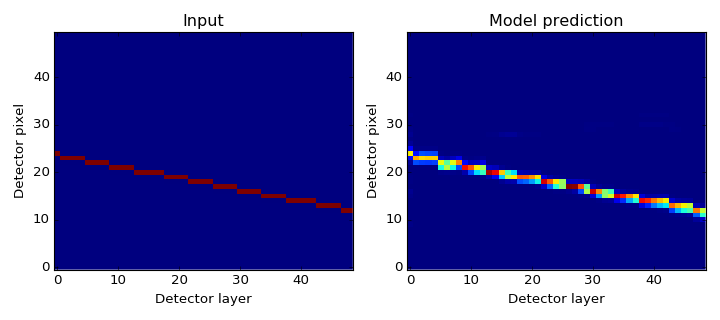

In [33]:
# Display one sample from the training set
display_idx = 72
draw_input_and_pred(train_input[display_idx], train_pred[display_idx])

## Two-track events

<IPython.core.display.Javascript object>


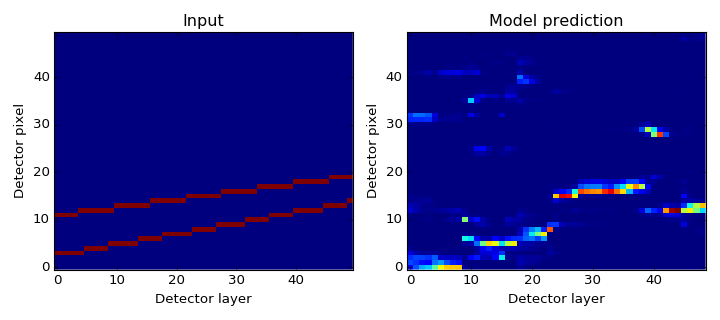

In [35]:
# Try adding two tracks into one image and see how the model does without any retraining
t1 = generate_straight_track(det_shape)
t2 = generate_straight_track(det_shape)
t3 = t1 + t2
t3_input = np.expand_dims(t3, 0)[:,:-1,:]
t3_pred = model1.predict(t3_input)

# Plot the event and the corresponding prediction
draw_input_and_pred(t3, t3_pred[0])

In [11]:
# Now lets generate events with 2 tracks each and train on that
events2 = sum([generate_straight_tracks(50000, det_shape) for i in range(2)])
train2_input = events2[:,:-1,:]
train2_target = events2[:,1:,:]

In [12]:
# Create a new model
model2 = build_model(num_hidden=20)
%time model2.fit(train2_input, train2_target, batch_size=500, nb_epoch=10)
train2_pred = model2.predict(train2_input)

Epoch 1/10
50000/50000 [==============================] - 7s - loss: 6.9413 - acc: 0.1328     
Epoch 2/10
50000/50000 [==============================] - 8s - loss: 5.1818 - acc: 0.2592     
Epoch 3/10
50000/50000 [==============================] - 7s - loss: 4.1913 - acc: 0.3059     
Epoch 4/10
50000/50000 [==============================] - 8s - loss: 3.7202 - acc: 0.3243     
Epoch 5/10
50000/50000 [==============================] - 8s - loss: 3.4944 - acc: 0.3294     
Epoch 6/10
50000/50000 [==============================] - 8s - loss: 3.3782 - acc: 0.3320     
Epoch 7/10
50000/50000 [==============================] - 7s - loss: 3.3106 - acc: 0.3309     
Epoch 8/10
50000/50000 [==============================] - 7s - loss: 3.2663 - acc: 0.3301     
Epoch 9/10
50000/50000 [==============================] - 8s - loss: 3.2337 - acc: 0.3310     
Epoch 10/10
50000/50000 [==============================] - 7s - loss: 3.2079 - acc: 0.3316     
CPU times: user 2min 13s, sys: 11.7 s, total: 2mi

In [36]:
# Display one sample from the training set
display_idx = 666
draw_input_and_pred(events2[display_idx], train2_pred[display_idx])

NameError: name 'events2' is not defined

## Single tracks with uniform noise
In training, the inputs to the network are the events with the tracks and noise. However, in this case the target is the not same event, but rather the track by itself (still shifted by 1 index). Let's see if we can get this to work.

<IPython.core.display.Javascript object>


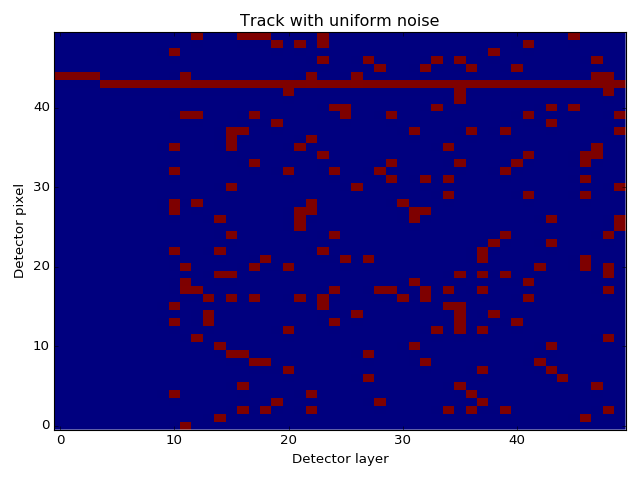

In [15]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=10)
events3 = tracks + noise
events3[events3 > 1] = 1

# Define the inputs and target
train3_input = events3[:,:-1,:]
train3_target = tracks[:,1:,:]

# Let's take a quick look at one of these noise events
plt.figure()
draw_event(events3[66], title='Track with uniform noise')

In [19]:
# Instantiate the model
model3 = build_model(num_hidden=50)
# Train the network
%time model3.fit(train3_input, train3_target, batch_size=500, nb_epoch=10)
# Get the final predictions from the entire training set
train3_pred = model3.predict(train3_input)

Epoch 1/10
100000/100000 [==============================] - 16s - loss: 2.3293 - acc: 0.3277    
Epoch 2/10
100000/100000 [==============================] - 17s - loss: 1.2171 - acc: 0.5795    
Epoch 3/10
100000/100000 [==============================] - 16s - loss: 0.9227 - acc: 0.6586    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 0.7814 - acc: 0.7015    
Epoch 5/10
100000/100000 [==============================] - 17s - loss: 0.6929 - acc: 0.7300    
Epoch 6/10
100000/100000 [==============================] - 15s - loss: 0.6329 - acc: 0.7500    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.5891 - acc: 0.7651    
Epoch 8/10
100000/100000 [==============================] - 15s - loss: 0.6237 - acc: 0.7612    
Epoch 9/10
100000/100000 [==============================] - 15s - loss: 0.5575 - acc: 0.7737    
Epoch 10/10
100000/100000 [==============================] - 15s - loss: 0.5189 - acc: 0.7889    
CPU times: user 4min 30s, sys

<IPython.core.display.Javascript object>


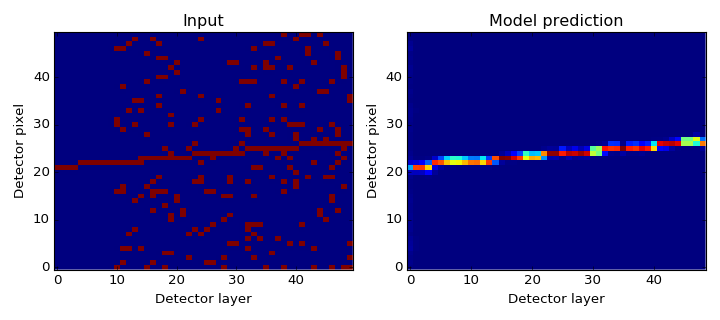

In [37]:
display_idx = 12050
draw_input_and_pred(events3[display_idx], train3_pred[display_idx])

let's try to make it a little more difficult by decreasing the seed size and increasing the noise level

<IPython.core.display.Javascript object>


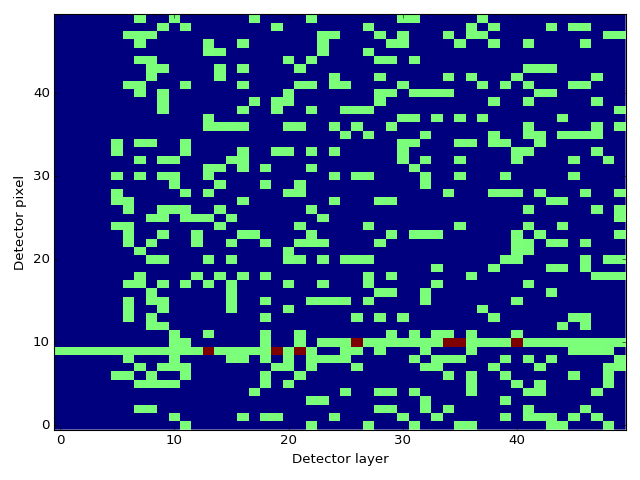

In [23]:
noise = generate_uniform_noise(len(tracks), det_shape, skip_layers=5, prob=0.2)
events4 = tracks + noise
train4_input = events4[:,:-1,:]
train4_target = tracks[:,1:,:]
plt.figure()
draw_event(events4[10])

In [24]:
model4 = build_model(num_hidden=50)
%time model4.fit(train4_input, train4_target, batch_size=500, nb_epoch=10)
train4_pred = model4.predict(train4_input)

Epoch 1/10
100000/100000 [==============================] - 17s - loss: 2.5383 - acc: 0.2868    
Epoch 2/10
100000/100000 [==============================] - 15s - loss: 1.5275 - acc: 0.4838    
Epoch 3/10
100000/100000 [==============================] - 15s - loss: 1.2050 - acc: 0.5652    
Epoch 4/10
100000/100000 [==============================] - 16s - loss: 1.0463 - acc: 0.6113    
Epoch 5/10
100000/100000 [==============================] - 14s - loss: 0.9392 - acc: 0.6408    
Epoch 6/10
100000/100000 [==============================] - 15s - loss: 0.8549 - acc: 0.6666    
Epoch 7/10
100000/100000 [==============================] - 16s - loss: 0.7926 - acc: 0.6856    
Epoch 8/10
100000/100000 [==============================] - 15s - loss: 0.7792 - acc: 0.6909    
Epoch 9/10
100000/100000 [==============================] - 15s - loss: 0.7214 - acc: 0.7087    
Epoch 10/10
100000/100000 [==============================] - 16s - loss: 0.8306 - acc: 0.6913    


<IPython.core.display.Javascript object>


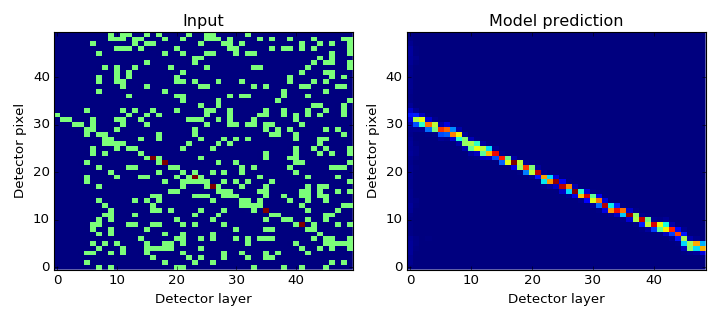

<IPython.core.display.Javascript object>


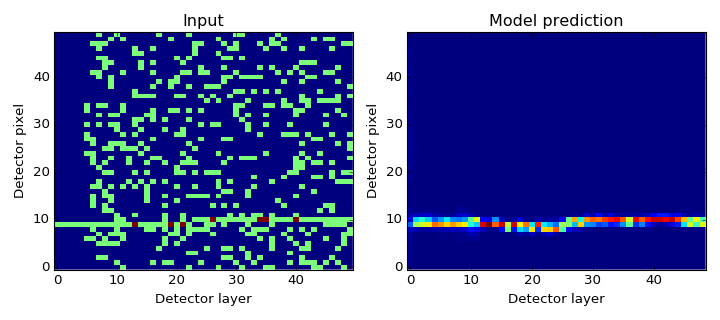

In [43]:
display_idx = 444
draw_input_and_pred(events4[display_idx], train4_pred[display_idx])

display_idx = 10
draw_input_and_pred(events4[display_idx], train4_pred[display_idx])

## Multi-track background

Now let's try the scenario where each event has background tracks in addition to the signal track.

In [53]:
# Generate the bkg data
bkgs = generate_track_bkg(tracks.shape[0], det_shape, tracks_per_event=2)
events5 = bkgs + tracks
events5[events5 > 1] = 1
train5_input = events5[:,:-1,:]
train5_target = tracks[:,1:,:]

In [62]:
model5 = build_model(num_hidden=50)
%time model5.fit(train5_input, train5_target, batch_size=200, nb_epoch=10)
train5_pred = model5.predict(train5_input)

Epoch 1/10
100000/100000 [==============================] - 37s - loss: 2.2645 - acc: 0.3632    
Epoch 2/10
100000/100000 [==============================] - 36s - loss: 1.4430 - acc: 0.5297    
Epoch 3/10
100000/100000 [==============================] - 35s - loss: 1.1950 - acc: 0.5822    
Epoch 4/10
100000/100000 [==============================] - 36s - loss: 1.0726 - acc: 0.6151    
Epoch 5/10
100000/100000 [==============================] - 35s - loss: 0.9801 - acc: 0.6402    
Epoch 6/10
100000/100000 [==============================] - 34s - loss: 0.9460 - acc: 0.6534    
Epoch 7/10
100000/100000 [==============================] - 36s - loss: 0.8851 - acc: 0.6706    
Epoch 8/10
100000/100000 [==============================] - 35s - loss: 0.8383 - acc: 0.6862    
Epoch 9/10
100000/100000 [==============================] - 34s - loss: 0.8302 - acc: 0.6914    
Epoch 10/10
100000/100000 [==============================] - 36s - loss: 0.7930 - acc: 0.7028    
CPU times: user 9min 56s, sys

<IPython.core.display.Javascript object>


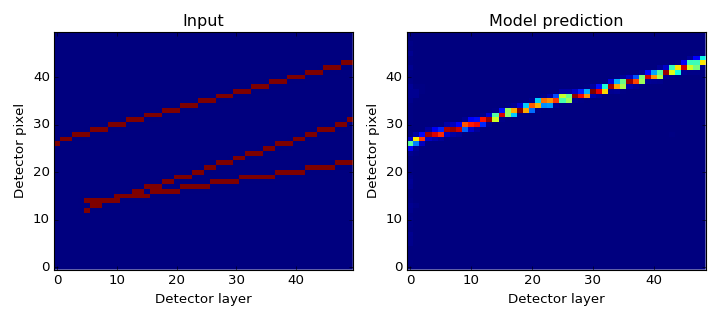

<IPython.core.display.Javascript object>


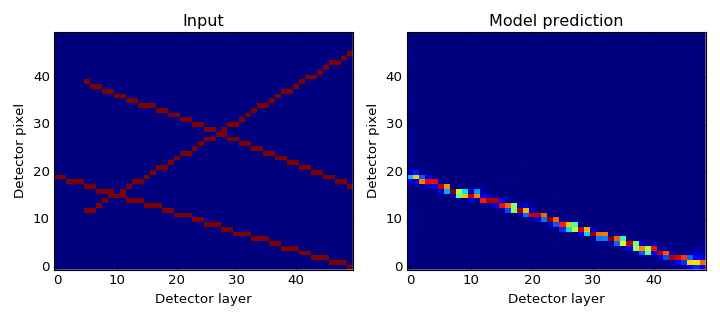

<IPython.core.display.Javascript object>


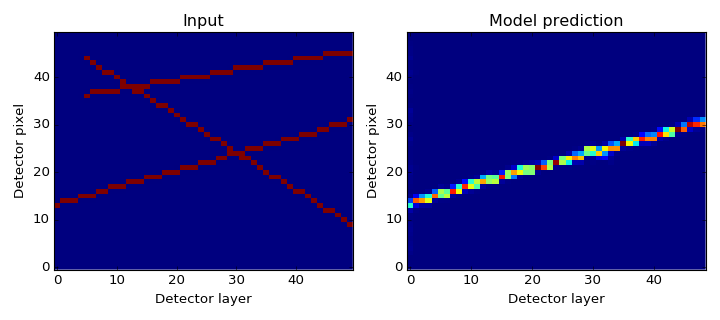

In [64]:
display_idx = 1234
draw_input_and_pred(events5[display_idx], train5_pred[display_idx])

display_idx = 5432
draw_input_and_pred(events5[display_idx], train5_pred[display_idx])

display_idx = 666
draw_input_and_pred(events5[display_idx], train5_pred[display_idx])